In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from glob import glob
import seaborn as sns
import librosa
from sklearn.preprocessing import normalize
from librosa.display import specshow


In [ ]:
def get_monitor_filenames(experiment_name,model_name):
    return sorted(glob(f"piano_rolls/logs/{experiment_name}/{model_name}/runs/*/monitor.csv"))

def get_monitor_dataframes(monitor_filenames):
    return [pd.read_csv(path, skiprows = 1) for path in monitor_filenames]

def get_mean_rewards(data_frames):
    reward_frames = pd.DataFrame([df["r"] for df in data_frames]).T
    return reward_frames.mean(axis=1), reward_frames.std(axis=1)


In [ ]:
experiment_name = "audio_target-8-notes"

ppo_paths = get_monitor_filenames(experiment_name,"WrappedPPO")
dqn_paths = get_monitor_filenames(experiment_name,"WrappedDQN")


ppo_dfs = get_monitor_dataframes(ppo_paths)
dqn_dfs = get_monitor_dataframes(dqn_paths)

# ppo_mean_rewards = get_mean_rewards(ppo_dfs)
# dqn_mean_rewards = get_mean_rewards(dqn_dfs)

# ppo_means, ppo_stds = get_mean_rewards(ppo_dfs)
# dqn_means, dqn_stds = get_mean_rewards(dqn_dfs)

#print(pd.DataFrame(np.concatenate([df["r"].to_numpy() for df in ppo_dfs])))


for dfs, name in zip([ppo_dfs,dqn_dfs], ["PPO","DQN"]):

    reward_array = np.concatenate([df["r"].rolling(500).mean().to_numpy() for df in dfs])
    timestep_array = np.concatenate([range(dfs[0]["r"].size)] * len(dfs))


    reward_frames = pd.DataFrame( {
        "Episode": timestep_array,
        "Reward": reward_array
    } ).dropna()

    sns.lineplot(data=reward_frames,x="Episode", y="Reward", ci="sd", label =name)



In [ ]:
experiment_name = "velocity-4-notes"

ppo_paths = get_monitor_filenames(experiment_name,"WrappedPPO")
ppo_dfs = get_monitor_dataframes(ppo_paths)

timestep_array = np.concatenate([range(ppo_dfs[0]["r"].size)] * len(ppo_dfs))

total_reward_array = np.concatenate([df["r"].rolling(500).mean().to_numpy() for df in ppo_dfs])
total_reward_frames = pd.DataFrame( {
    "Episode": timestep_array,
    "Reward": total_reward_array
} ).dropna()

frequency_reward_array = np.concatenate([df["frequency_reward"].rolling(500).mean().to_numpy() for df in ppo_dfs])
frequency_reward_frames = pd.DataFrame( {
    "Episode": timestep_array,
    "Reward": frequency_reward_array/2
} ).dropna()

envelope_reward_array = np.concatenate([df["envelope_reward"].rolling(500).mean().to_numpy() for df in ppo_dfs])
envelope_reward_frames = pd.DataFrame( {
    "Episode": timestep_array,
    "Reward": envelope_reward_array/2
} ).dropna()

sns.lineplot(data=total_reward_frames,x="Episode", y="Reward", ci="sd", label ="Total reward")
sns.lineplot(data=frequency_reward_frames,x="Episode", y="Reward", ci="sd", label ="Frequency reward / 2")
sns.lineplot(data=envelope_reward_frames,x="Episode", y="Reward", ci="sd", label ="Envelope reward / 2")




In [ ]:
model_name_dict = {"WrappedPPO": "PPO", "WrappedDQN" : "DQN"}

experiment_name_dict = {
                        "piano_roll_target-4-notes":"Piano roll target, 4 notes",
                        "piano_roll_target-8-notes":"Piano roll target, 8 notes",
                        "audio_target-4-notes": "Audio target, 4 notes",
                        "audio_target-8-notes": "Audio target, 8 notes",
                        "velocity-4-notes" : "Controlling velocity, 4 notes",
                        "velocity-8-notes": "Controlling velocity, 8 notes",
                        "single_param-FREQUENCY-4-notes" : "Controlling frequency, 4 notes",
                        "single_param-FREQUENCY-8-notes" : "Controlling frequency, 8 notes",
                        "single_param-LOSS_FACTOR-4-notes" : "Controlling loss factor, 4 notes",
                        "single_param-LOSS_FACTOR-8-notes" : "Controlling loss factor, 8 notes",
                        "single_param-PLUCK_POSITION-4-notes" : "Controlling pluck position, 4 notes",
                        "single_param-PLUCK_POSITION-8-notes" : "Controlling pluck position, 8 notes",
                        "single_param-AMPLITUDE-4-notes" : "Controlling amplitude, 4 notes",
                        "single_param-AMPLITUDE-8-notes" : "Controlling amplitude, 8 notes",
                        "multi_param-4-notes": "Controlling multiple parameters, 4 notes",
                        "multi_param-8-notes": "Controlling multiple parameters, 8 notes"
                        }

def get_model_names(instrument, experiment_name):
    folder_path = f"{instrument}/logs/{experiment_name}/*/"
    model_paths = glob(folder_path)
    model_names = [path.split('/')[-2] for path in model_paths]
    return model_names

def get_monitor_filenames(instrument, experiment_name,model_name):
    filename_expression = f"{instrument}/logs/{experiment_name}/{model_name}/runs/*/monitor.csv"
    filenames = glob(filename_expression)
    return sorted(filenames)



def get_monitor_dataframes(monitor_paths):
    return [pd.read_csv(path, skiprows = 1) for path in monitor_paths]

def get_dataframes_by_model(instrument, experiment_name):
    model_names = get_model_names(instrument, experiment_name)

    paths_by_model = {model_name : get_monitor_filenames(instrument, experiment_name,model_name) for model_name in model_names}

    return {model_name : get_monitor_dataframes(model_paths) 
                                    for model_name,model_paths in paths_by_model.items() }

def plot_composible_reward(dataframes_by_model, experiment_name, rolling_window = 500):
    
    for model_name, dataframes in dataframes_by_model.items():

        episode_count = dataframes[0]['r'].size
        n_runs = len(dataframes)

        timestep_array = np.concatenate([range(episode_count)] * n_runs)

        total_reward = np.concatenate([df['r'].rolling(rolling_window).mean().to_numpy() for df in dataframes])
        frequency_reward = np.concatenate([df['frequency_reward'].rolling(rolling_window).mean().to_numpy() for df in dataframes])
        envelope_reward = np.concatenate([df['envelope_reward'].rolling(rolling_window).mean().to_numpy() for df in dataframes])

        rolling_avg_rewards = [total_reward, frequency_reward/2, envelope_reward/2]

        reward_labels = ["Total reward", "Frequency reward/2", "Envelope reward/2"]
        
        plt.figure(dpi = 180)

        for reward_array, reward_label in zip(rolling_avg_rewards,reward_labels):

            reward_frames = pd.DataFrame( {
                "Episode": timestep_array,
                "Reward": reward_array
            } ).dropna()

            sns.lineplot(data=reward_frames,x="Episode", y="Reward", ci="sd", label = reward_label)
        
        title = f"{experiment_name_dict[experiment_name]} - {model_name_dict[model_name]}"
        plt.title(title)
        plt.savefig("figures/" + "-".join(title.split()))
        plt.show()



def plot_non_composible_reward(dataframes_by_model, experiment_name, rolling_window = 500):

    plt.figure(dpi = 180)

    for model_name, dataframes in dataframes_by_model.items():

        episode_count = dataframes[0]['r'].size
        n_runs = len(dataframes)

        timestep_array = np.concatenate([range(episode_count)] * n_runs)
        reward_array = np.concatenate([df['r'].rolling(rolling_window).mean().to_numpy() for df in dataframes])


        reward_frames = pd.DataFrame( {
            "Episode": timestep_array,
            "Reward": reward_array
        } ).dropna()

        label = model_name_dict[model_name]


        sns.lineplot(data=reward_frames,x="Episode", y="Reward", ci="sd", label = label)
        
    title = f"{experiment_name_dict[experiment_name]}"
    plt.title(title)
    plt.savefig("figures/" + "-".join(title.split()))
    plt.show()

def plot_experiment_rewards(instrument, experiment_name):

    dataframes_by_model = get_dataframes_by_model(instrument, experiment_name)

    model_keys = list(dataframes_by_model.values())[0][0].keys().tolist()

    has_composible_rewards = "frequency_reward" in model_keys and "envelope_reward" in model_keys

    if has_composible_rewards:
        plot_composible_reward(dataframes_by_model, experiment_name)
    else:
        plot_non_composible_reward(dataframes_by_model, experiment_name)

os.makedirs("figures/", exist_ok=True)


instrument = "physical_models"
experiment_name = "single_param-AMPLITUDE-8-notes"
plot_experiment_rewards(instrument, experiment_name)






In [ ]:
instrument = "physical_models"
experiment_name = "multi_param-8-notes"

dataframes_by_model = get_dataframes_by_model(instrument,experiment_name)

total_timesteps = list(dataframes_by_model.values())[0][0]

for model_name, dataframes in dataframes_by_model.items():

    total_episodes = len(dataframes[0])

    run_length = np.mean([df["t"].values[-1] for df in dataframes])

    avg_episode_length = run_length/total_episodes

    #print(f"Average total runtime, {model_name} - {run_length}")
    print(f"Average episode time, {model_name} - {avg_episode_length:0.2}")



In [ ]:
def get_foldernames(instrument, experiment_name, model_name):
    foldername_expression = f"{instrument}/logs/{experiment_name}/{model_name}/runs/*"
    foldernames = glob(foldername_expression)
    return sorted(foldernames)


def get_target_prediction_pairs(foldernames, target_name, prediction_name):

    loader = pd.read_csv if target_name.split(".")[-1] == "csv" else np.load
    target_prediction_pairs = [(loader(f"{foldername}/{target_name}"),
                                loader(f"{foldername}/{prediction_name}")) for foldername in foldernames]
    return target_prediction_pairs


def print_average_correct_predictions(instrument, experiment_names):
    for experiment_name in experiment_names:
        model_names = get_model_names(instrument, experiment_name)

        for model_name in model_names:

            foldernames = get_foldernames(
                instrument, experiment_name, model_name)
            target_prediction_pairs = get_target_prediction_pairs(
                foldernames, "target_piano_roll.npy", "predicted_piano_roll.npy")

            scores = []

            for target, prediction in target_prediction_pairs:
                score = np.count_nonzero(
                    np.sum(abs(target-prediction), axis=0) == 0)
                scores.append(score)

            avg_score = np.mean(scores)

            experiment_name_string = experiment_name_dict[experiment_name]
            model_name_string = model_name_dict[model_name]

            message = f"{experiment_name_string} - {model_name_string}: {avg_score:1.2}"

            print(message)


def print_velocity_accuracy():
    instrument = "piano_rolls"
    experiment_names = ["velocity-4-notes", "velocity-8-notes"]
    model_name = "WrappedPPO"

    for experiment_name in experiment_names:
        foldernames = get_foldernames(instrument, experiment_name, model_name)
        target_prediction_pairs = get_target_prediction_pairs(
            foldernames, "target_piano_roll.npy", "predicted_piano_roll.npy")

        note_scores = []
        velocity_scores = []

        for target, prediction in target_prediction_pairs:

            correct_note_count = np.count_nonzero(
                np.sum(target*prediction, axis=0) != 0)
            correct_velocity_count = np.count_nonzero(
                abs(np.sum(target, axis=0) - np.sum(prediction, axis=0)) == 0)

            note_scores.append(correct_note_count)
            velocity_scores.append(correct_velocity_count)

        avg_note_score = np.mean(note_scores)
        avg_velocity_score = np.mean(velocity_scores)

        experiment_name_string = experiment_name_dict[experiment_name]
        model_name_string = model_name_dict[model_name]

        message = f"{experiment_name_string} - {model_name_string}:\n" + \
            f"Correct notes: {avg_note_score:1.2}\n" + \
            f"Correct velocity: {avg_velocity_score:1.2}\n"

        print(message)


def print_frequency_predictions():
    instrument = "physical_models"
    experiment_names = ["single_param-FREQUENCY-4-notes",
                        "single_param-FREQUENCY-8-notes"]

    for experiment_name in experiment_names:

        model_names = get_model_names(instrument, experiment_name)

        for model_name in model_names:
            foldernames = get_foldernames(
                instrument, experiment_name, model_name)

            target_prediction_pairs = get_target_prediction_pairs(
                foldernames, "target_parameters.csv", "predicted_parameters.csv")

            score = []
            perfect_reward_score = []

            for target, prediction in target_prediction_pairs:

                ratio = (target["Frequency"] /
                         prediction["Frequency"]).to_numpy()

                abs_log_ratio = abs(np.log2(ratio))

                score = np.concatenate((score, abs_log_ratio))

                if np.sum(prediction["Reward"]) >= prediction["Reward"].size:
                    perfect_reward_score = np.concatenate(
                        (perfect_reward_score, abs_log_ratio))

            mean_log_ratio = np.mean(score)
            mean_perfect_log_ratio = np.mean(perfect_reward_score)

            experiment_name_string = experiment_name_dict[experiment_name]
            model_name_string = model_name_dict[model_name]

            message = f"{experiment_name_string} - {model_name_string}:\n" + \
                f"Mean log ratio: {mean_log_ratio:1.3}\n" + \
                f"Mean log ratio of perfect scores: {mean_perfect_log_ratio:1.2}\n"
            print(message)


def print_ks_predictions():

    instrument = "physical_models"
    experiment_names = ["multi_param-8-notes"]
    # ["single_param-PLUCK_POSITION-4-notes",
    #                     "single_param-PLUCK_POSITION-8-notes",
    #                     "single_param-LOSS_FACTOR-4-notes",
    #                     "single_param-LOSS_FACTOR-8-notes",
    #                     "single_param-AMPLITUDE-4-notes",
    #                     "single_param-AMPLITUDE-8-notes",
    #                     "multi_param-4-notes",
    #                     "multi_param-8-notes"]

    for experiment_name in experiment_names:

        model_names = get_model_names(instrument, experiment_name)

        for model_name in model_names:
            foldernames = get_foldernames(
                instrument, experiment_name, model_name)

            target_prediction_pairs = get_target_prediction_pairs(
                foldernames, "target_parameters.csv", "predicted_parameters.csv")

            pluck_position_scores = []
            loss_factor_scores = []
            amplitude_scores = []

            for target, prediction in target_prediction_pairs:

                pluck_position_score = np.mean(
                    abs(target["Pluck position"]-prediction["Pluck position"]) == 0)
                pluck_position_scores.append(pluck_position_score)

                loss_factor_score = np.mean(
                    abs(target["Loss factor"]-prediction["Loss factor"]) == 0)
                loss_factor_scores.append(loss_factor_score)

                amplitude_score = np.mean(
                    abs(target["Amplitude"]-prediction["Amplitude"]) == 0)
                amplitude_scores.append(amplitude_score)
                
                param = "Pluck position"

                if not np.array_equal(target[param],prediction[param]):
                    print(target[param].to_numpy())
                    print(prediction[param].to_numpy())

            mean_pluck_position_score = np.mean(pluck_position_scores)
            mean_loss_factor_score = np.mean(loss_factor_scores)
            mean_amplitude_score = np.mean(amplitude_scores)

            experiment_name_string = experiment_name_dict[experiment_name]
            model_name_string = model_name_dict[model_name]

            message = f"{experiment_name_string} - {model_name_string}:\n" + \
                f"Mean pluck position score: {mean_pluck_position_score:1.3}\n" + \
                f"Mean loss factor score: {mean_loss_factor_score:1.3}\n" \
                f"Mean amplitude score: {mean_amplitude_score:1.3}\n"
            print(message)


# instrument = "piano_rolls"
# experiment_names = ["piano_roll_target-4-notes",
#                     "piano_roll_target-8-notes",
#                     "audio_target-4-notes",
#                     "audio_target-8-notes",
#                     "velocity-4-notes",
#                     "velocity-8-notes"]

print_frequency_predictions()


In [ ]:
from random import randint
from typing import List, Tuple
from rl_instruments.environments.physical_models import ControlableParameter

def create_target_parameters(controlable_parameter: ControlableParameter,
                             controlable_array: List[str]) -> Tuple[List[float],
                                                                    List[float],
                                                                    List[float],
                                                                    List[float]]:

    n_notes = len(controlable_array)
    target_params = [controlable_array if controlable_parameter is param else [
        param.default_value]*n_notes for param in sorted(ControlableParameter)]

    return target_params

def generate_random_parameters(n_notes: int, controlable_parameter: ControlableParameter) -> List[int]:

    min_value = controlable_parameter.min_value
    max_value = controlable_parameter.max_value
    n = controlable_parameter.n

    return [min_value + randint(0, n-1) * (max_value - min_value) / (n-1) for _ in range(n_notes)]

controlable_parameter = ControlableParameter.LOSS_FACTOR
controlable_array = generate_random_parameters(4, controlable_parameter)
create_target_parameters(controlable_parameter, controlable_array)

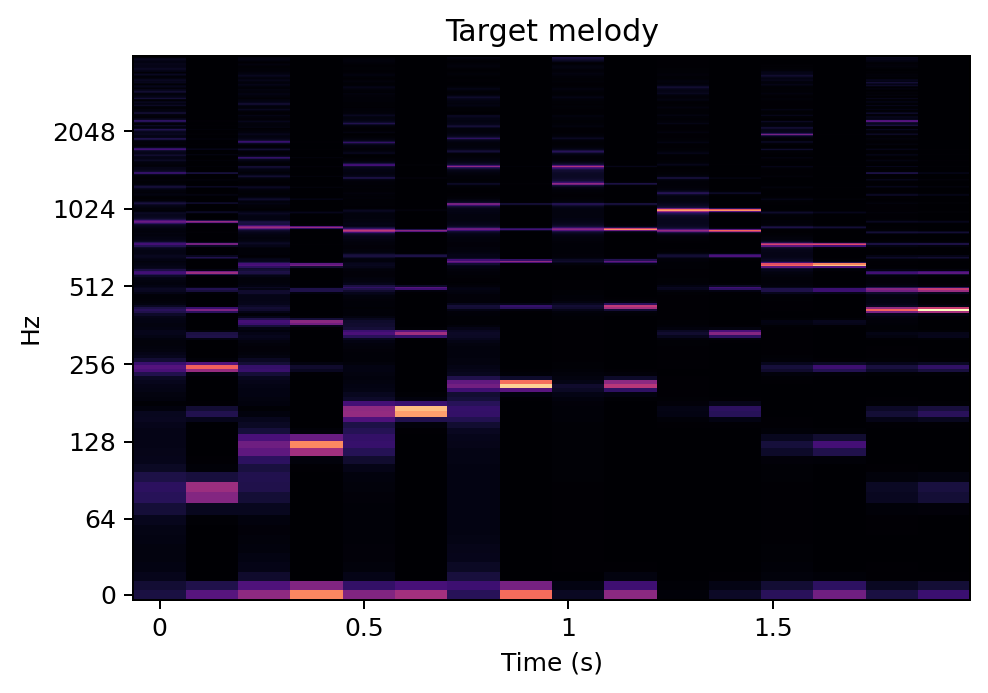

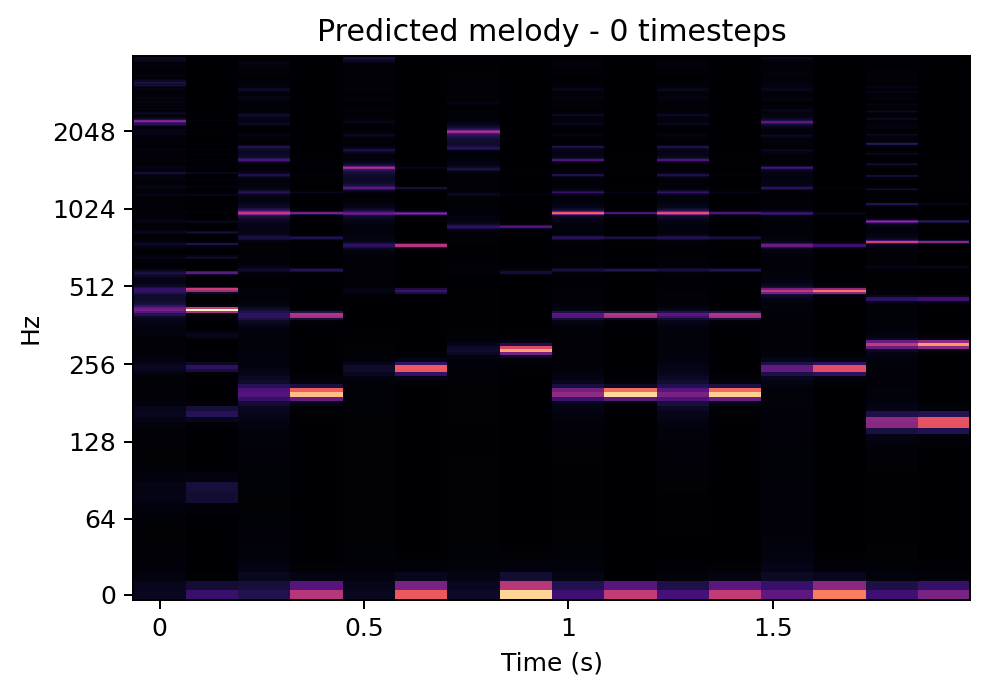

Timesteps: 0
Reward: 5.56
   Frequency  Pluck position  Loss factor  Amplitude
0       82.0             0.1        0.910        0.5
1      195.0             0.3        0.910        1.0
2      240.0             0.1        0.910        1.0
3      282.0             0.1        0.910        1.0
4      195.0             0.3        0.996        1.0
5      195.0             0.3        0.910        1.0
6      237.0             0.3        0.910        0.5
7      149.0             0.3        0.910        1.0


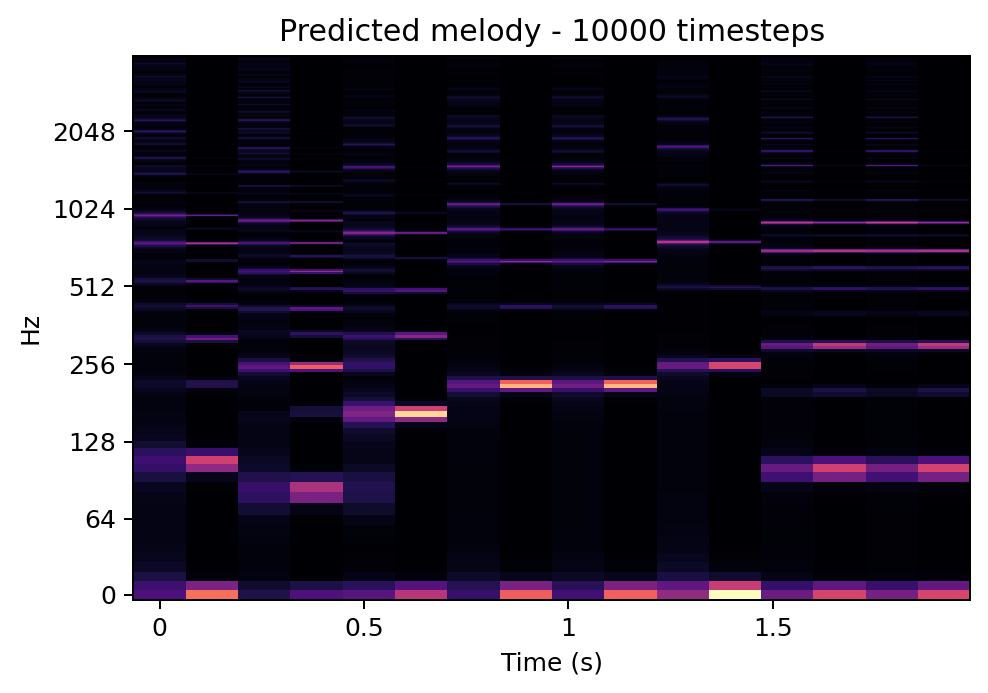

Timesteps: 10000
Reward: 6.28
   Frequency  Pluck position  Loss factor  Amplitude
0      106.0             0.5        0.910        0.5
1       83.0             0.5        0.996        0.5
2      162.0             0.5        0.910        0.5
3      209.0             0.5        0.910        0.5
4      209.0             0.5        0.910        0.5
5      249.0             0.5        0.910        1.0
6       99.0             0.5        0.910        1.0
7       99.0             0.5        0.910        0.5


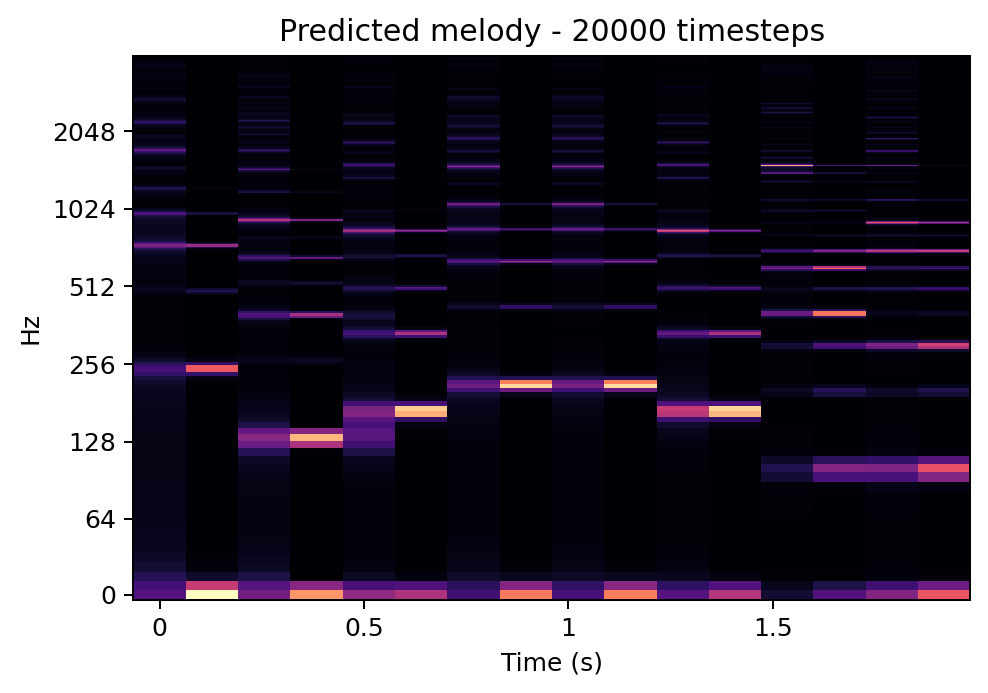

Timesteps: 20000
Reward: 6.65
   Frequency  Pluck position  Loss factor  Amplitude
0      241.0             0.5        0.910        0.5
1      130.0             0.5        0.996        0.5
2      164.0             0.5        0.910        0.5
3      209.0             0.5        0.910        0.5
4      209.0             0.5        0.910        1.0
5      164.0             0.5        0.910        1.0
6       99.0             0.1        0.910        1.0
7       99.0             0.5        0.910        1.0


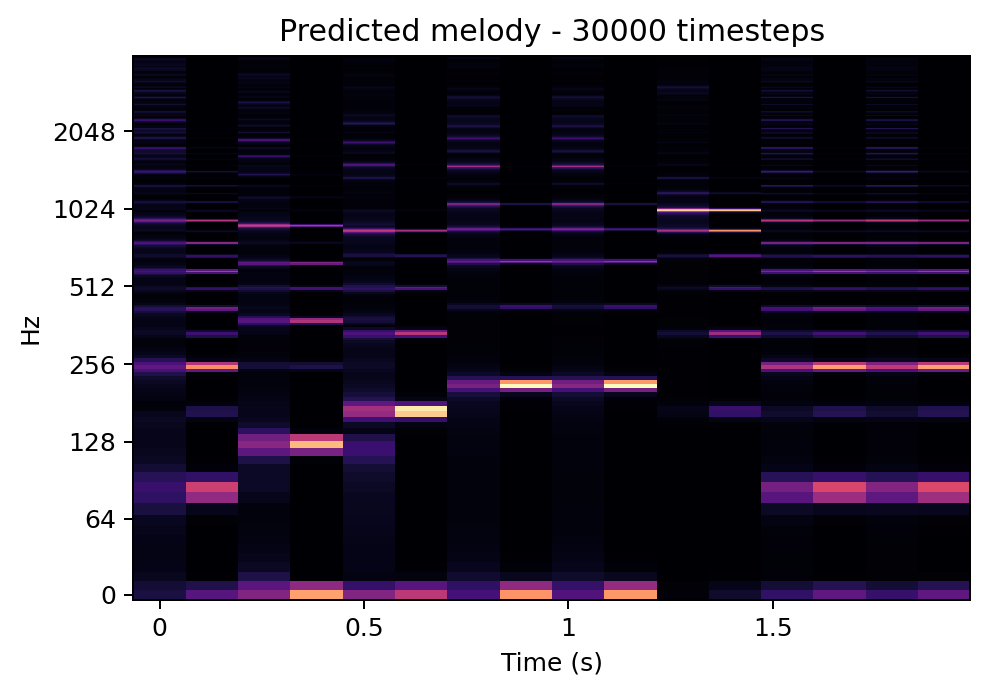

Timesteps: 30000
Reward: 7.25
   Frequency  Pluck position  Loss factor  Amplitude
0       83.0             0.5        0.910        0.5
1      125.0             0.5        0.996        0.5
2      164.0             0.5        0.910        0.5
3      209.0             0.5        0.910        0.5
4      209.0             0.5        0.910        0.5
5      164.0             0.1        0.910        1.0
6       83.0             0.5        0.910        1.0
7       83.0             0.5        0.910        1.0


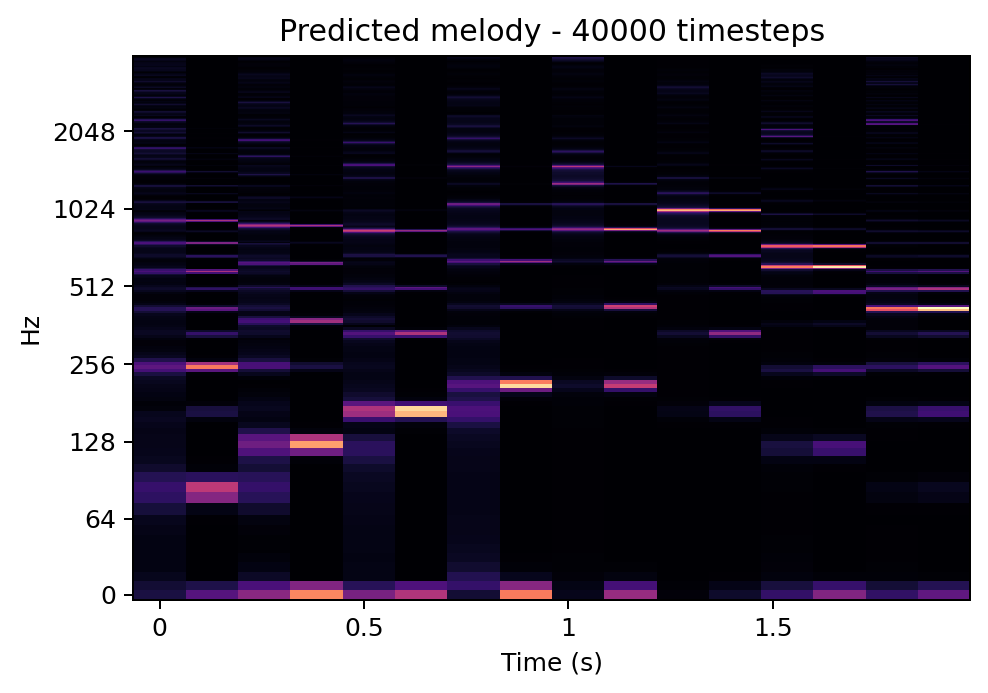

Timesteps: 40000
Reward: 7.78
   Frequency  Pluck position  Loss factor  Amplitude
0       83.0             0.5        0.996        0.5
1      125.0             0.5        0.996        0.5
2      164.0             0.5        0.996        0.5
3      209.0             0.5        0.910        0.5
4      209.0             0.1        0.910        0.5
5      164.0             0.1        0.910        1.0
6      121.0             0.1        0.910        1.0
7       83.0             0.1        0.910        1.0


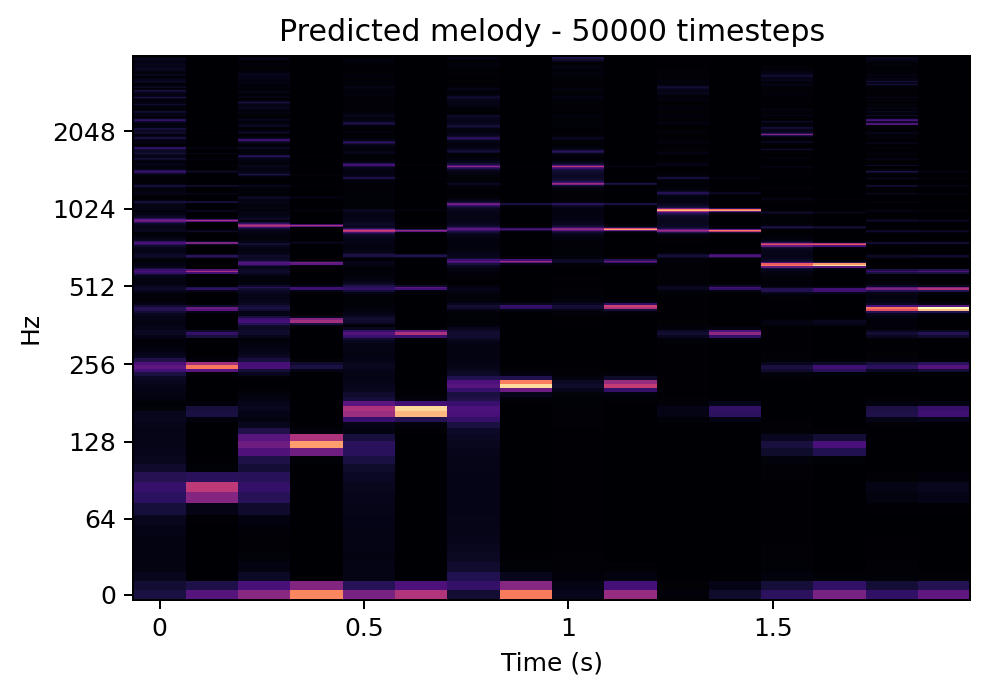

Timesteps: 50000
Reward: 7.85
   Frequency  Pluck position  Loss factor  Amplitude
0       83.0             0.5        0.996        0.5
1      125.0             0.5        0.996        0.5
2      164.0             0.5        0.996        0.5
3      209.0             0.5        0.910        0.5
4      209.0             0.1        0.910        0.5
5      164.0             0.1        0.910        1.0
6      123.0             0.1        0.910        1.0
7       83.0             0.1        0.910        1.0


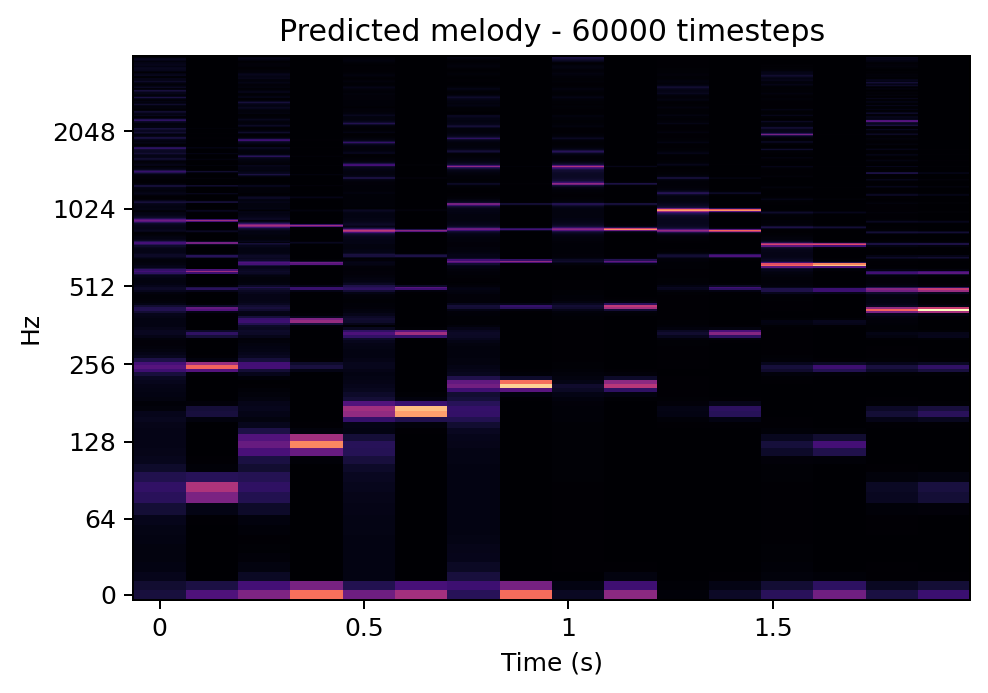

Timesteps: 60000
Reward: 7.92
   Frequency  Pluck position  Loss factor  Amplitude
0       83.0             0.5        0.996        0.5
1      125.0             0.5        0.996        0.5
2      164.0             0.5        0.996        0.5
3      209.0             0.5        0.996        0.5
4      209.0             0.1        0.910        1.0
5      164.0             0.1        0.910        1.0
6      123.0             0.1        0.910        1.0
7       82.0             0.1        0.910        1.0


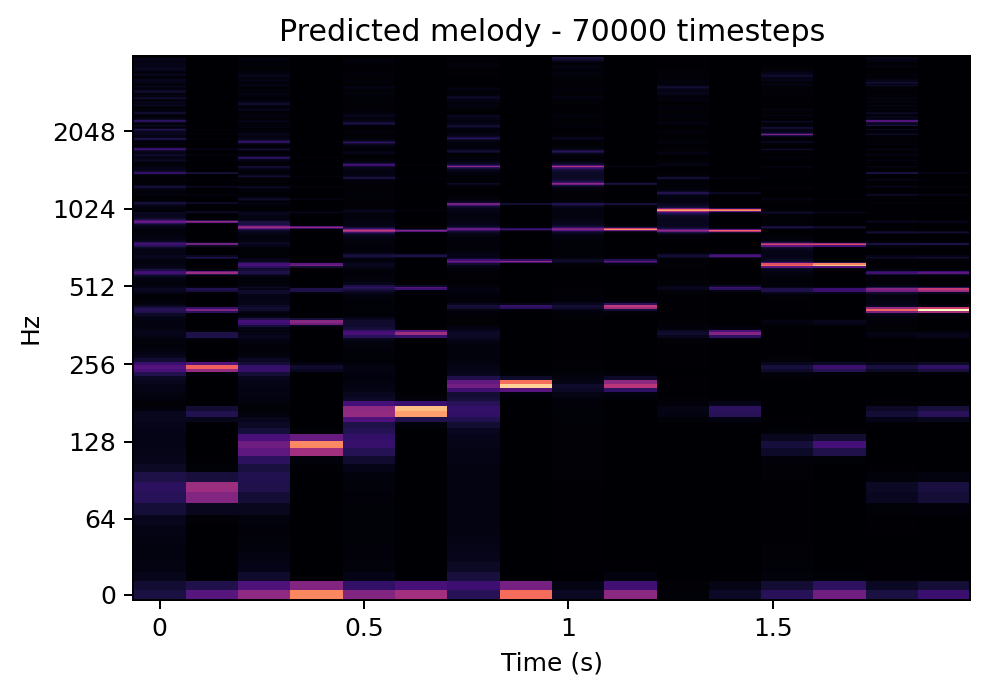

Timesteps: 70000
Reward: 8.0
   Frequency  Pluck position  Loss factor  Amplitude
0       82.0             0.5        0.996        0.5
1      122.0             0.5        0.996        0.5
2      164.0             0.5        0.996        0.5
3      209.0             0.5        0.996        0.5
4      209.0             0.1        0.910        1.0
5      164.0             0.1        0.910        1.0
6      123.0             0.1        0.910        1.0
7       82.0             0.1        0.910        1.0


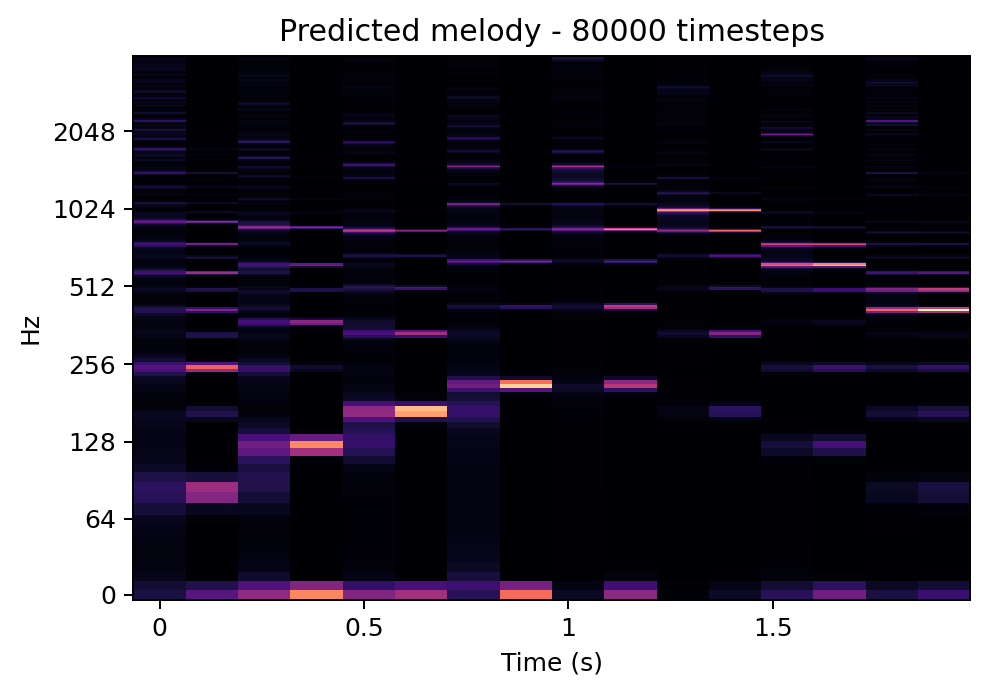

Timesteps: 80000
Reward: 8.0
   Frequency  Pluck position  Loss factor  Amplitude
0       82.0             0.5        0.996        0.5
1      122.0             0.5        0.996        0.5
2      164.0             0.5        0.996        0.5
3      209.0             0.5        0.996        0.5
4      209.0             0.1        0.910        1.0
5      164.0             0.1        0.910        1.0
6      123.0             0.1        0.910        1.0
7       82.0             0.1        0.910        1.0


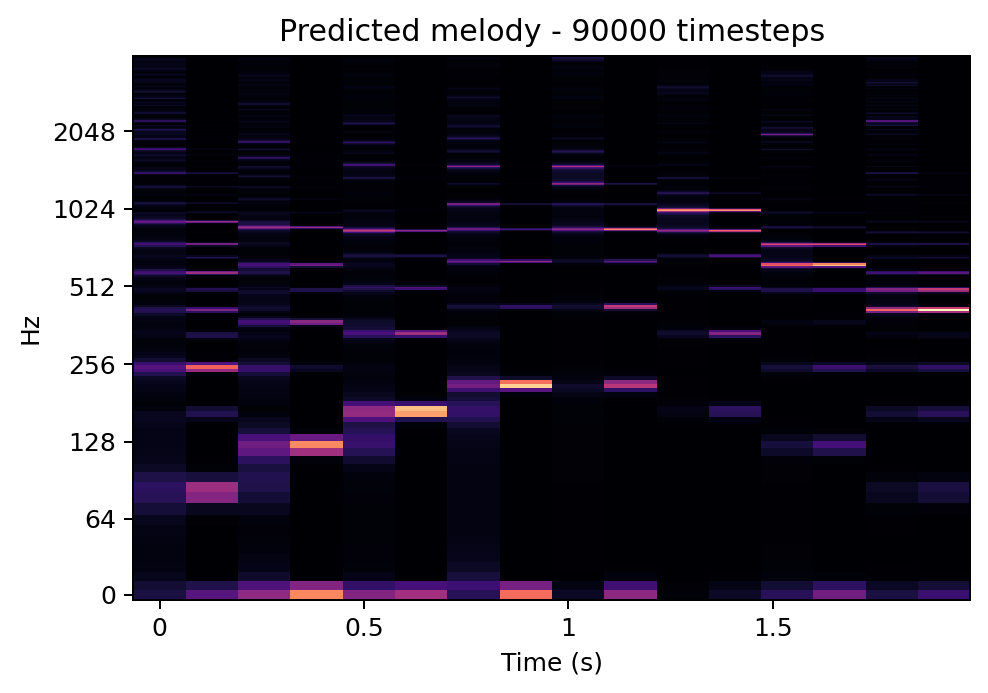

Timesteps: 90000
Reward: 8.0
   Frequency  Pluck position  Loss factor  Amplitude
0       82.0             0.5        0.996        0.5
1      122.0             0.5        0.996        0.5
2      164.0             0.5        0.996        0.5
3      209.0             0.5        0.996        0.5
4      209.0             0.1        0.910        1.0
5      164.0             0.1        0.910        1.0
6      123.0             0.1        0.910        1.0
7       82.0             0.1        0.910        1.0


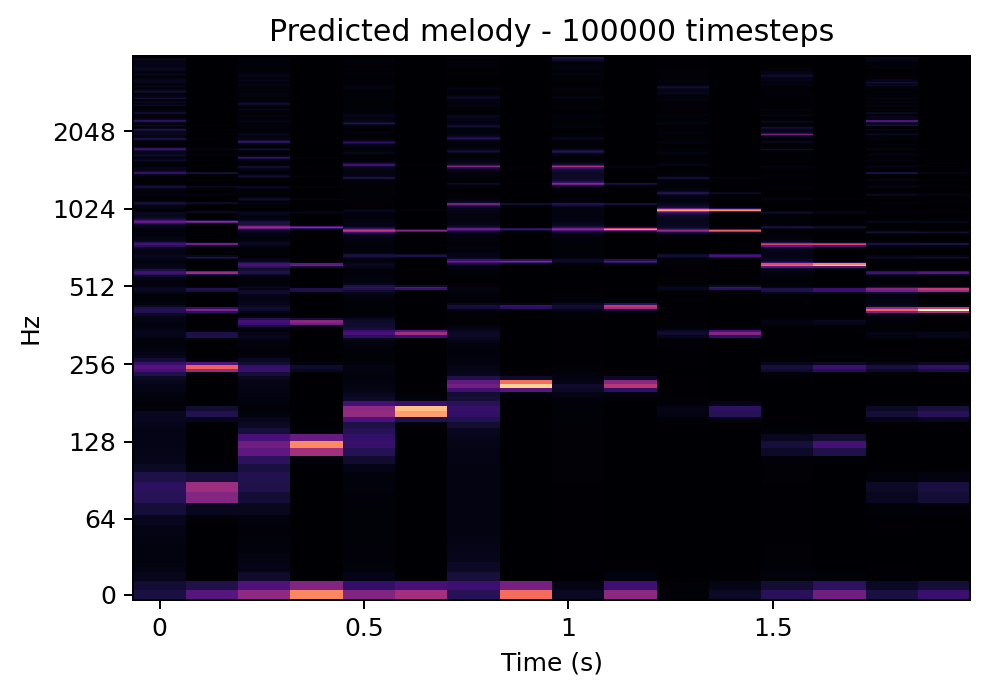

Timesteps: 100000
Reward: 8.0
   Frequency  Pluck position  Loss factor  Amplitude
0       82.0             0.5        0.996        0.5
1      122.0             0.5        0.996        0.5
2      164.0             0.5        0.996        0.5
3      209.0             0.5        0.996        0.5
4      209.0             0.1        0.910        1.0
5      164.0             0.1        0.910        1.0
6      123.0             0.1        0.910        1.0
7       82.0             0.1        0.910        1.0


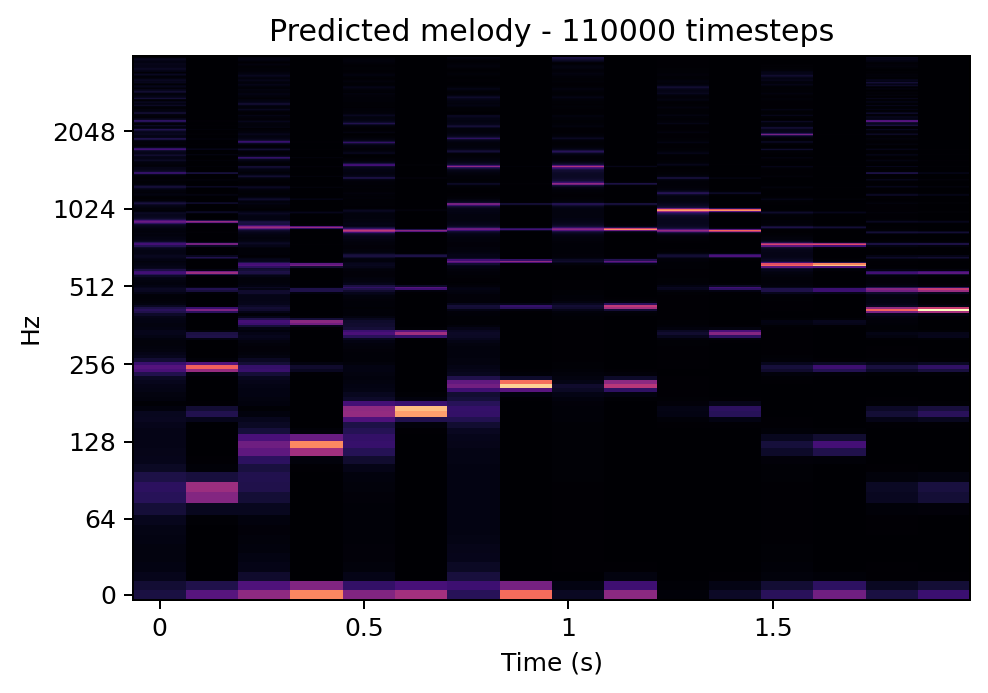

Timesteps: 110000
Reward: 8.0
   Frequency  Pluck position  Loss factor  Amplitude
0       82.0             0.5        0.996        0.5
1      122.0             0.5        0.996        0.5
2      164.0             0.5        0.996        0.5
3      210.0             0.5        0.996        0.5
4      207.0             0.1        0.910        1.0
5      164.0             0.1        0.910        1.0
6      123.0             0.1        0.910        1.0
7       82.0             0.1        0.910        1.0


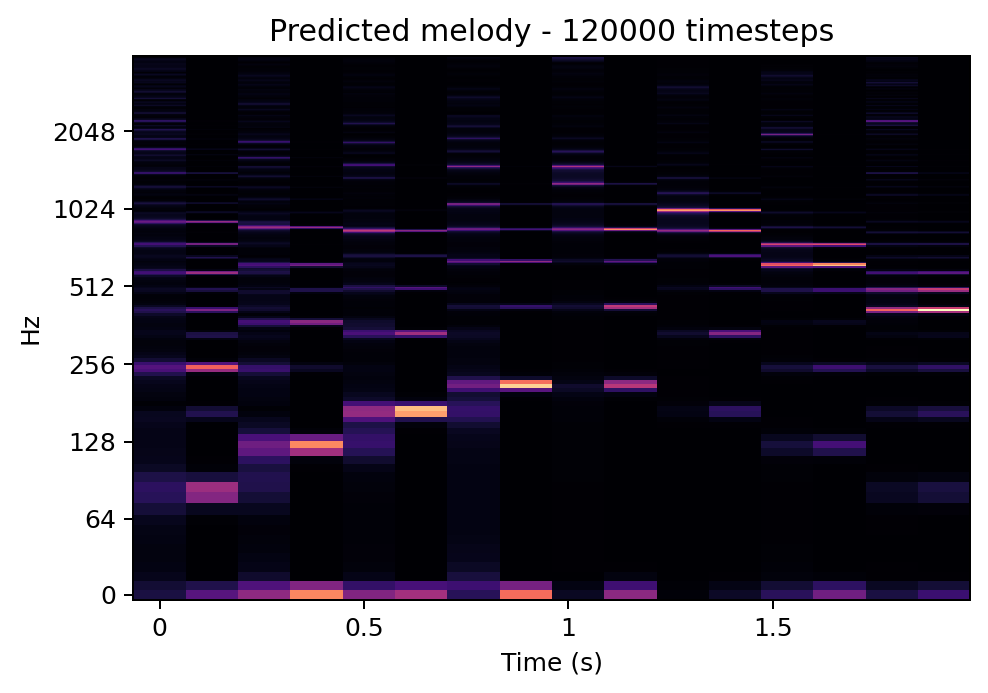

Timesteps: 120000
Reward: 8.0
   Frequency  Pluck position  Loss factor  Amplitude
0       82.0             0.5        0.996        0.5
1      122.0             0.5        0.996        0.5
2      164.0             0.5        0.996        0.5
3      210.0             0.5        0.996        0.5
4      207.0             0.1        0.910        1.0
5      165.0             0.1        0.910        1.0
6      123.0             0.1        0.910        1.0
7       82.0             0.1        0.910        1.0


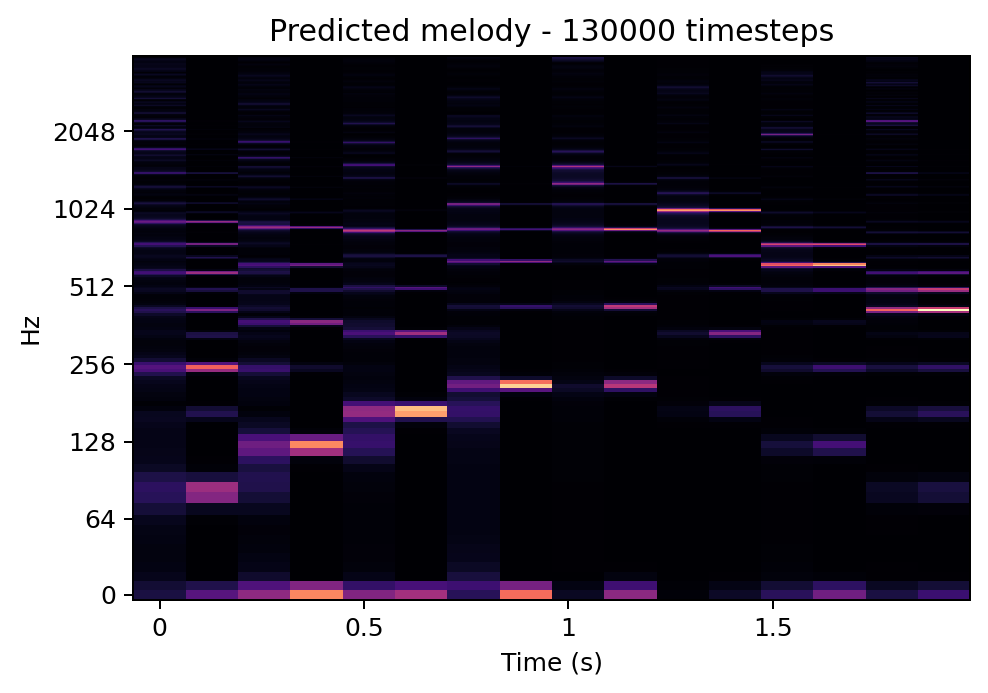

Timesteps: 130000
Reward: 8.0
   Frequency  Pluck position  Loss factor  Amplitude
0       82.0             0.5        0.996        0.5
1      122.0             0.5        0.996        0.5
2      164.0             0.5        0.996        0.5
3      210.0             0.5        0.996        0.5
4      209.0             0.1        0.910        1.0
5      164.0             0.1        0.910        1.0
6      123.0             0.1        0.910        1.0
7       82.0             0.1        0.910        1.0


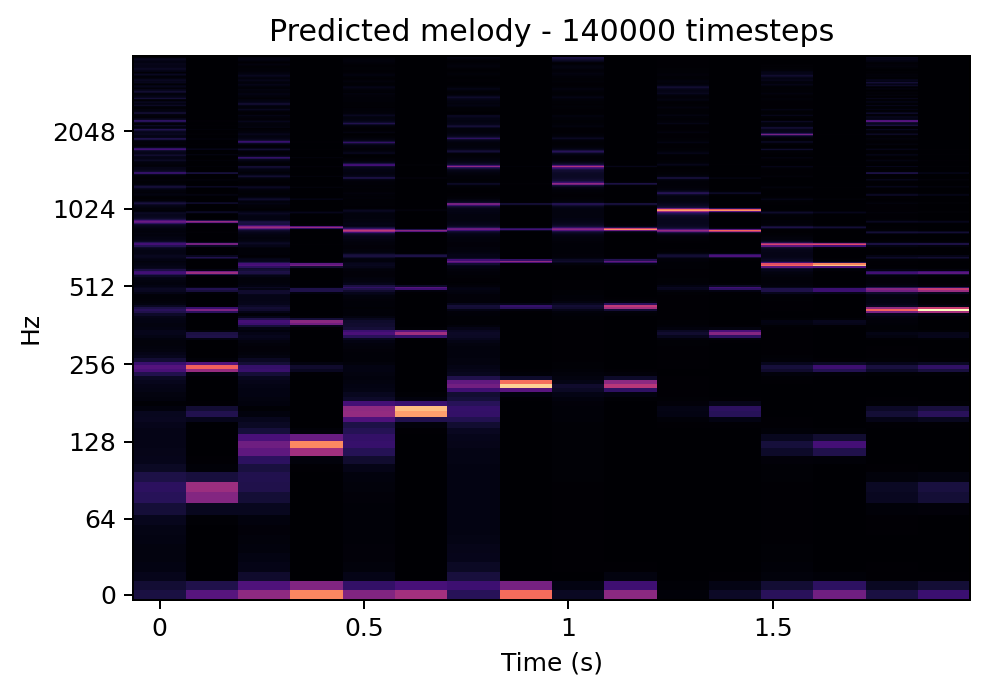

Timesteps: 140000
Reward: 8.0
   Frequency  Pluck position  Loss factor  Amplitude
0       82.0             0.5        0.996        0.5
1      122.0             0.5        0.996        0.5
2      165.0             0.5        0.996        0.5
3      210.0             0.5        0.996        0.5
4      207.0             0.1        0.910        1.0
5      165.0             0.1        0.910        1.0
6      123.0             0.1        0.910        1.0
7       82.0             0.1        0.910        1.0


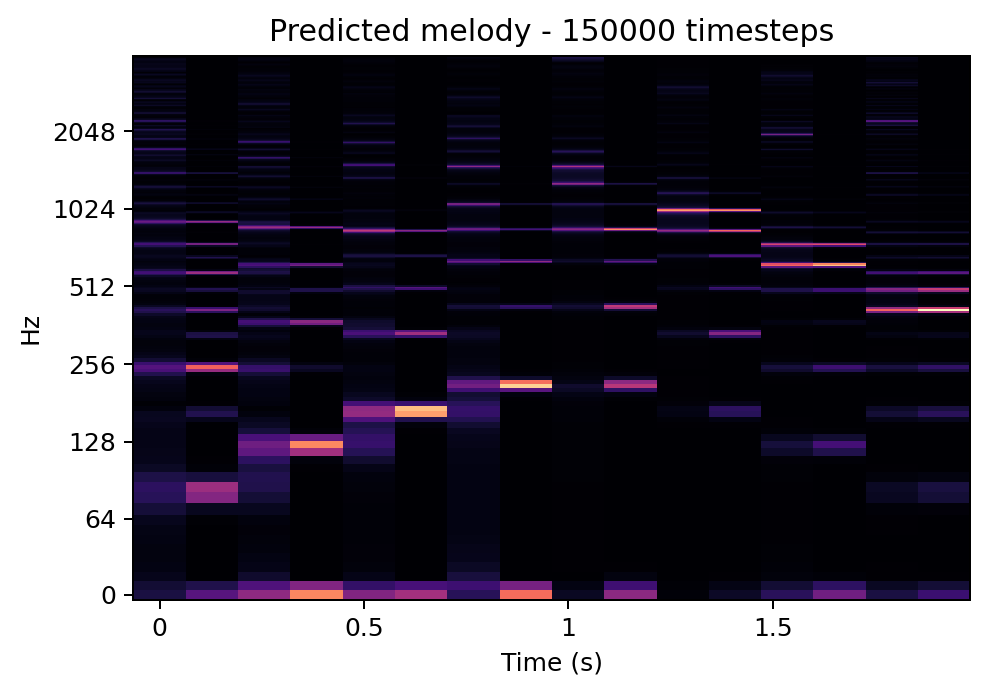

Timesteps: 150000
Reward: 8.0
   Frequency  Pluck position  Loss factor  Amplitude
0       82.0             0.5        0.996        0.5
1      122.0             0.5        0.996        0.5
2      164.0             0.5        0.996        0.5
3      210.0             0.5        0.996        0.5
4      206.0             0.1        0.910        1.0
5      164.0             0.1        0.910        1.0
6      123.0             0.1        0.910        1.0
7       82.0             0.1        0.910        1.0


In [82]:
def make_illustration_stfts():
    plt.figure(dpi = 180)
    
    experiment_path = "physical_models/logs/training_illustration/"

    target_folder_path = "physical_models/logs/training_illustration/target/"

    interval_paths = glob(f"{experiment_path}*/")
    interval_paths.remove(target_folder_path)
    interval_paths.sort(key=lambda x: int(x.split('/')[-2]))

    os.makedirs("figures/illustration/", exist_ok=True)

    target_audio, _ = librosa.load(
        target_folder_path + "target_audio.wav", sr=8000)

    stft = normalize(
        np.abs(librosa.stft(
            target_audio, n_fft=1024, win_length=1024, hop_length=1024)),
        axis=0)

    specshow(stft, sr=8000, n_fft=1024, win_length=1024, hop_length=1024, x_axis='s', y_axis='log')
    plt.title("Target melody")
    plt.savefig("figures/illustration/target")
    plt.show()
    
    for path in interval_paths:
        wav_path = path + "predicted_audio.wav"
        param_path = path + "predicted_parameters.csv"
        target_audio, _ = librosa.load(wav_path, sr=8000)

        stft = normalize(
            np.abs(librosa.stft(
                target_audio, n_fft=1024, win_length=1024, hop_length=1024)),
            axis=0)

        plt.figure(dpi = 180)

        specshow(stft, sr=8000, n_fft=1024, win_length=1024, hop_length=1024, x_axis='s', y_axis='log')

        timesteps = path.split("/")[-2]
        title = f"Predicted melody - {timesteps} timesteps"
        plt.title(title)
        plt.savefig("figures/illustration/" + "-".join(title.split()))
        plt.show()

        params = pd.read_csv(param_path)

        reward = np.sum(params["Reward"])
        print(f"Timesteps: {timesteps}")
        print(f"Reward: {reward:1.3}")
        print(params[["Frequency", "Pluck position", "Loss factor", "Amplitude"]])

    # model_names = [path.split('/')[-2] for path in model_paths]


make_illustration_stfts()
